<a href="https://colab.research.google.com/github/SalamUddin844/A-combination-of-CNN-and-SVM-for-Pneumonia-Detection-using-X-ray-Image-Dataset/blob/main/Pneumonia_detection_using_Hybrid_model_(CNN%2BSVM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, MaxPooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.applications import MobileNetV2
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import keras.utils as image
import seaborn as sns
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.image as mpimg
from PIL import Image
import shutil
sns.set()
%matplotlib inline


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
!unzip /content/drive/MyDrive/Colab_Notebooks/pneumonia/pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: pneumonia/train/normal/IM-0419-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0420-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0421-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0423-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0424-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0425-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0427-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0428-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0429-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0429-0001-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0429-0001-0002.jpeg  
  inflating: pneumonia/train/normal/IM-0430-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0431-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0432-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0433-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0434-0001.jpeg  
  inflating: pneumonia/train/normal/IM-0435

# **Directories**

In [19]:
train_dir = '/content/pneumonia/train'
test_dir = '/content/pneumonia/test'
dir = '/content/pneumonia/train'

# **Data Distribution**

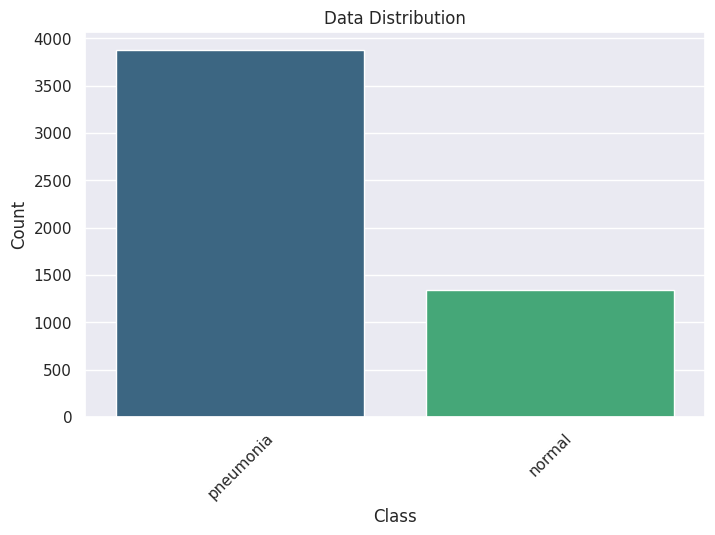

In [20]:
class_labels = os.listdir(dir)
image_counts = [len(os.listdir(os.path.join(dir, label))) for label in class_labels]
plt.figure(figsize=(8,5))
sns.barplot(x=class_labels, y=image_counts, palette="viridis")
plt.title('Data Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# **Data Augmentation For test train and validtion generator**

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
train_generator.class_indices
test_generator.class_indices
validation_generator.class_indices

Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


{'normal': 0, 'pneumonia': 1}

# **Train Image Visualization**

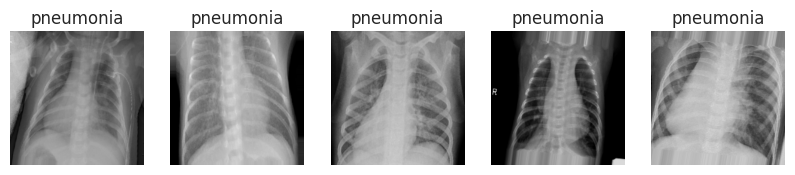

In [23]:
import matplotlib.pyplot as plt

batch = train_generator.next()
images, labels = batch
class_indices = train_generator.class_indices
reverse_class_indices = {v: k for k, v in class_indices.items()}
num_images = 5
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(images[i])
    plt.title(reverse_class_indices[int(labels[i])])
    plt.axis('off')

plt.show()


# **Hybrid model Architecture (CNN+SVM)**

In [7]:
cnn_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(train_generator, validation_data=validation_generator, epochs=10)
train_cnn_features = cnn_model.predict(train_generator)
validation_cnn_features = cnn_model.predict(validation_generator)

train_cnn_features = train_cnn_features.reshape((train_cnn_features.shape[0], -1))
validation_cnn_features = validation_cnn_features.reshape((validation_cnn_features.shape[0], -1))


svm_model = SVC()
svm_model.fit(train_cnn_features, train_generator.labels)

Epoch 1/10
163/163 [==============================] - 169s 972ms/step - loss: 1.1449 - accuracy: 0.8641 - val_loss: 0.1952 - val_accuracy: 0.9170
Epoch 2/10
163/163 [==============================] - 151s 927ms/step - loss: 0.2228 - accuracy: 0.9087 - val_loss: 0.1384 - val_accuracy: 0.9511
Epoch 3/10
163/163 [==============================] - 150s 924ms/step - loss: 0.1995 - accuracy: 0.9204 - val_loss: 0.1665 - val_accuracy: 0.9392
Epoch 4/10
163/163 [==============================] - 153s 938ms/step - loss: 0.1867 - accuracy: 0.9237 - val_loss: 0.1352 - val_accuracy: 0.9503
Epoch 5/10
163/163 [==============================] - 147s 901ms/step - loss: 0.1943 - accuracy: 0.9266 - val_loss: 0.1601 - val_accuracy: 0.9438
Epoch 6/10
163/163 [==============================] - 146s 896ms/step - loss: 0.1839 - accuracy: 0.9273 - val_loss: 0.1357 - val_accuracy: 0.9494
Epoch 7/10
163/163 [==============================] - 146s 896ms/step - loss: 0.1752 - accuracy: 0.9308 - val_loss: 0.1285 -

SVC()

# **Model Evalution**





In [8]:
from sklearn.metrics import accuracy_score, log_loss

# Define a function for categorical cross entropy
def categorical_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred), axis=-1)

# Train set
train_cnn_features = cnn_model.predict(train_generator).reshape((train_generator.n, -1))
svm_train_predictions = svm_model.predict(train_cnn_features)
svm_train_accuracy = accuracy_score(train_generator.labels, svm_train_predictions)
svm_train_loss = np.mean(categorical_cross_entropy(train_generator.labels, svm_train_predictions))

# Validation set
validation_cnn_features = cnn_model.predict(validation_generator).reshape((validation_generator.n, -1))
svm_validation_predictions = svm_model.predict(validation_cnn_features)
svm_validation_accuracy = accuracy_score(validation_generator.labels, svm_validation_predictions)
svm_validation_loss = np.mean(categorical_cross_entropy(validation_generator.labels, svm_validation_predictions))

# Test set
test_cnn_features = cnn_model.predict(test_generator).reshape((test_generator.n, -1))
svm_test_predictions = svm_model.predict(test_cnn_features)
svm_test_accuracy = accuracy_score(test_generator.labels, svm_test_predictions)
svm_test_loss = np.mean(categorical_cross_entropy(test_generator.labels, svm_test_predictions))

# Print results
print(f"SVM Train Accuracy: {svm_train_accuracy}, Loss: {svm_train_loss}")
print(f"SVM Validation Accuracy: {svm_validation_accuracy}, Loss: {svm_validation_loss}")
print(f"SVM Test Accuracy: {svm_test_accuracy}, Loss: {svm_test_loss}")


20/20 [==============================] - 6s 313ms/step
SVM Train Accuracy: 0.7429064417177914, Loss: 3.871902798380235e-12
SVM Validation Accuracy: 0.7429064417177914, Loss: 3.871902798380235e-12
SVM Test Accuracy: 0.625, Loss: 3.8968828164343015e-13


# **Confusion Matrix**

# **Train, Test and Validation Accuracy Visualization**

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate accuracy for train set
train_cnn_features = cnn_model.predict(train_generator).reshape((train_generator.n, -1))
svm_train_predictions = svm_model.predict(train_cnn_features)
svm_train_accuracy = accuracy_score(train_generator.labels, svm_train_predictions)
print(f"SVM Train Accuracy: {svm_train_accuracy}")

# Calculate accuracy for validation set
validation_cnn_features = cnn_model.predict(validation_generator).reshape((validation_generator.n, -1))
svm_validation_predictions = svm_model.predict(validation_cnn_features)
svm_validation_accuracy = accuracy_score(validation_generator.labels, svm_validation_predictions)
print(f"SVM Validation Accuracy: {svm_validation_accuracy}")

# Calculate accuracy for test set
test_cnn_features = cnn_model.predict(test_generator).reshape((test_generator.n, -1))
svm_test_predictions = svm_model.predict(test_cnn_features)
svm_test_accuracy = accuracy_score(test_generator.labels, svm_test_predictions)
print(f"SVM Test Accuracy: {svm_test_accuracy}")


163/163 [==============================] - 112s 685ms/step
SVM Train Accuracy: 0.7429064417177914
163/163 [==============================] - 47s 290ms/step
SVM Validation Accuracy: 0.7429064417177914
20/20 [==============================] - 6s 300ms/step
SVM Test Accuracy: 0.625


# **Prediction**

In [11]:
img_path = '/content/pneumonia/test/pneumonia/person100_bacteria_479.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.

cnn_features = cnn_model.predict(img)
cnn_features = cnn_features.reshape((cnn_features.shape[0], -1))
svm_prediction = svm_model.predict(cnn_features)

if svm_prediction == 0:
    print("Healthy")
else:
    print("Pneumonia")


1/1 [==============================] - 0s 123ms/step
Pneumonia
1/1 [==============================] - 0s 123ms/step
Pneumonia
